This notebook generates plots for Figure 5 of the Kipoi manuscript.

In [273]:
import numpy as np
import m_kipoi
from copy import deepcopy
import os
import pandas as pd
from plotnine import *
from m_kipoi.utils import read_pkl, write_pkl
import matplotlib
import matplotlib.pyplot as plt
from m_kipoi.config import get_data_dir
from tqdm import tqdm
from m_kipoi.exp.splicing.data import get_dbscsnv_Xy, get_clinvar_ext_Xy

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
ddir = get_data_dir()

In [274]:
# Use these Kipoi models
models = ["MaxEntScan/3prime", "MaxEntScan/5prime", "HAL", "labranchor"]

### Data

#### ClinVar

In [275]:
clinvar_file = f"{ddir}/processed/splicing/clinvar/annotated_vcf/20180429.filtered/clinvar_ext_Xy.pkl"
if os.path.exists(clinvar_file):
    X_clinvar, y_clinvar = read_pkl(clinvar_file)
else:
    X_clinvar, y_clinvar = get_clinvar_ext_Xy()
    write_pkl((X_clinvar, y_clinvar), clinvar_file)

In [276]:
print(y_clinvar.mean())
print(len(y_clinvar))

0.6218811626511189
11663


In [277]:
X_clinvar['early_stop'] = X_clinvar.early_stop.astype(bool)
y_clinvar = y_clinvar[~X_clinvar['early_stop']]
X_clinvar = X_clinvar[~X_clinvar['early_stop']]

#### dbscSNV

In [278]:
dbscsnv_file = f"{ddir}/processed/splicing/dbscSNV/annotated_vcf/variants/dbscsnv_Xy.pkl"
if os.path.exists(dbscsnv_file):
    X_dbscsnv, y_dbscsnv = read_pkl(dbscsnv_file)
else:
    X_dbscsnv, y_dbscsnv = get_dbscsnv_Xy()
    write_pkl((X_dbscsnv, y_dbscsnv), dbscsnv_file)

## Features

In [333]:
kipoi_features = ['MaxEntScan/3prime_alt',
                  'MaxEntScan/3prime_ref',
                  'MaxEntScan/3prime_isna',
                  'MaxEntScan/5prime_alt',
                  'MaxEntScan/5prime_ref',
                  'MaxEntScan/5prime_isna',
                  'HAL_ref',
                  'HAL_alt',
                  'HAL_isna',
                  'labranchor_logit_alt',
                  'labranchor_logit_ref',
                  'labranchor_isna']

In [281]:
kipoi_na_features = [x for x in kipoi_features if x.endswith("_isna")]

In [282]:
dbscsnv_model_features = ['PWM_ref', 'PWM_alt',
                          'MES_ref', 'MES_alt', 
                          'NNSplice_ref', 'NNSplice_alt', 
                          'HSF_ref', 'HSF_alt', 
                          'GeneSplicer_ref', 'GeneSplicer_alt', 
                          'GENSCAN_ref', 'GENSCAN_alt', 
                          'NetGene2_ref', 'NetGene2_alt', 
                          'SplicePredictor_ref', 'SplicePredictor_alt']

In [283]:
conservation_features = ['phyloP46way_placental', 'phyloP46way_primate', 'CADD_raw', 'CADD_phred']

In [284]:
dbscsnv_dbscsnv_feat = ['dbscSNV_rf_score', 'dbscSNV_rf_score_isna']

In [285]:
clinvar_cons_feat = ['CADD_raw', 'CADD_phred', 'phyloP46way_placental', 'phyloP46way_primate']
clinvar_dbscSNV_feat = ['dbscSNV_rf_score', 'dbscSNV_rf_score_isna']
spidex_feat = ['dpsi_max_tissue', 'dpsi_zscore', 'dpsi_max_tissue_isna', 'dpsi_zscore_isna']

In [286]:
dbscsnv_features = dbscsnv_model_features + conservation_features

## Modeling

In [287]:
# Scikit-learn imports
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn_pandas import DataFrameMapper

from m_kipoi.metrics import classification_metric, classification_metrics, BootstrapMetric, MetricsOrderedDict

In [288]:
class ZeroImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(X).fillna(0).copy()

In [289]:
def preproc(features):
    """Pre-processing pipeline
    """
    return DataFrameMapper([
            (features, [ZeroImputer(), 
                        sklearn.preprocessing.StandardScaler(),
                       ]),
        ])

In [290]:
model = LogisticRegression()

In [291]:
np.random.seed(42)

In [292]:
def evaluate(df, y, features, model, model_name):
        perm = np.random.permutation(len(df))  # permute rows
        ret = cross_validate(Pipeline([('preproc', preproc(features)), 
                                       ('model', model)]), 
                             df.iloc[perm], y[perm], scoring=['accuracy', 'roc_auc'], cv=10, n_jobs=10, return_train_score=True)
        means = pd.DataFrame(ret).describe().loc['mean']
        means.index = "mean_" + means.index
        sds = pd.DataFrame(ret).describe().loc['std']
        sds.index = "std_" + sds.index
        return pd.DataFrame([{**dict(means), **dict(sds), "model_name": model_name}])

In [293]:
def run_model_groups(df, y, model_groups,
                     feature_subset=kipoi_features,
                     model=LogisticRegressionCV(penalty="l1", solver='liblinear', scoring="roc_auc", cv=3, n_jobs=1)):
    res = []
    use_features = []
    for mg in tqdm(model_groups):
        use_features += [f for f in df.columns if f.startswith(mg) and f in feature_subset]
        if mg=='labranchor':
            mg = 'labranchor (KipoiSplice4)'
        res.append(evaluate(df, y, use_features, model, model_name=mg))
    return pd.concat(res)

In [294]:
res_dbscsnv = run_model_groups(X_dbscsnv, y_dbscsnv, models, model=model)

100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


In [295]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, kipoi_features + conservation_features, 
                                          model=model,
                                          model_name="KipoiSplice4 w/ cons."))

In [296]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, dbscsnv_model_features + conservation_features,
                                          model=model,
                                          model_name="dbscSNV"))

In [297]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, spidex_feat,
                                          model=model,
                                          model_name="SPIDEX"))

In [298]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, spidex_feat + clinvar_cons_feat,
                                          model=model,
                                          model_name="SPIDEX w/ cons."))

In [299]:
res_clinvar = run_model_groups(X_clinvar, y_clinvar, models, model=model)

100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


In [300]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, kipoi_features + clinvar_cons_feat, 
                                          model=model,
                                          model_name="KipoiSplice4 w/ cons."))

In [301]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, dbscsnv_dbscsnv_feat,
                                          model=model,
                                          model_name="dbscSNV"))

In [302]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, spidex_feat,
                                          model=model,
                                          model_name="SPIDEX"))

In [303]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, spidex_feat + clinvar_cons_feat,
                                          model=model,
                                          model_name="SPIDEX w/ cons."))

In [304]:
y_clinvar.mean()

0.5888940737284181

In [305]:
np.sum(y_clinvar==0)

4405

In [306]:
y_clinvar.size

10715

In [334]:
X_clinvar[kipoi_features].describe()

,MaxEntScan/3prime_alt,MaxEntScan/3prime_ref,MaxEntScan/3prime_isna,MaxEntScan/5prime_alt,MaxEntScan/5prime_ref,MaxEntScan/5prime_isna,HAL_ref,HAL_alt,HAL_isna,labranchor_logit_alt,labranchor_logit_ref,labranchor_isna
count,4475.0000,4475.0000,10715.0000,3562.0000,3562.0000,10715.0000,6588.0000,6588.0000,10715.0000,4381.0000,4381.0000,10715.0000
mean,5.0437,8.3806,0.5824,2.0892,8.1955,0.6676,13.7271,9.9510,0.3852,-1.1731,-1.2202,0.5911
std,4.9767,2.9834,0.4932,4.0857,2.6756,0.4711,3.1775,5.4993,0.4867,1.7940,1.9516,0.4916
...,...,...,...,...,...,...,...,...,...,...,...,...
50%,6.1099,8.6842,1.0000,1.4502,8.6801,1.0000,13.7792,11.0239,0.0000,-1.1175,-1.1014,1.0000
75%,9.1340,10.2223,1.0000,4.1052,9.7877,1.0000,15.7671,14.3217,1.0000,-0.0416,0.0168,1.0000
max,14.7292,14.9268,1.0000,11.8065,11.8065,1.0000,26.8472,26.8472,1.0000,3.6642,3.7983,1.0000


### Plot

In [308]:
import matplotlib.pyplot as plt

In [309]:
cm = plt.get_cmap('tab10')

In [310]:
list(res_dbscsnv.model_name[:5])

['MaxEntScan/3prime',
 'MaxEntScan/5prime',
 'HAL',
 'labranchor (KipoiSplice4)',
 'KipoiSplice4 w/ cons.']

In [311]:
list(res_dbscsnv.model_name[5:])

['dbscSNV', 'SPIDEX', 'SPIDEX w/ cons.']

In [312]:
kipoi_model_names = [
    'MaxEntScan/3prime',
     '+MaxEntScan/5prime',
     '+HAL',
     '+labranchor',
     '+conservation (KipoiSplice4)']

In [313]:
res_clinvar

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_roc_auc,mean_train_accuracy,mean_train_roc_auc,model_name,std_fit_time,std_score_time,std_test_accuracy,std_test_roc_auc,std_train_accuracy,std_train_roc_auc
0,0.0383,0.0073,0.7458,0.7796,0.7458,0.7797,MaxEntScan/3prime,0.0170,0.0032,0.0113,0.0135,0.0013,0.0015
0,0.0505,0.0071,0.8327,0.8962,0.8329,0.8964,MaxEntScan/5prime,0.0181,0.0029,0.0099,0.0111,0.0013,0.0013
0,0.0703,0.0383,0.8332,0.9058,0.8334,0.9060,HAL,0.0316,0.0197,0.0137,0.0099,0.0017,0.0012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0476,0.0095,0.8579,0.9156,0.8580,0.9158,dbscSNV,0.0199,0.0075,0.0123,0.0099,0.0014,0.0011
0,0.0846,0.0191,0.7541,0.8205,0.7541,0.8208,SPIDEX,0.0347,0.0068,0.0107,0.0118,0.0016,0.0013
0,0.1600,0.0233,0.8537,0.9202,0.8531,0.9205,SPIDEX w/ cons.,0.0563,0.0087,0.0081,0.0068,0.0009,0.0008


In [314]:
other_model_names = ['dbscSNV', 'SPIDEX', 'SPIDEX+conservation']

In [315]:
cv_other_model_names = list(res_clinvar.model_name[5:])

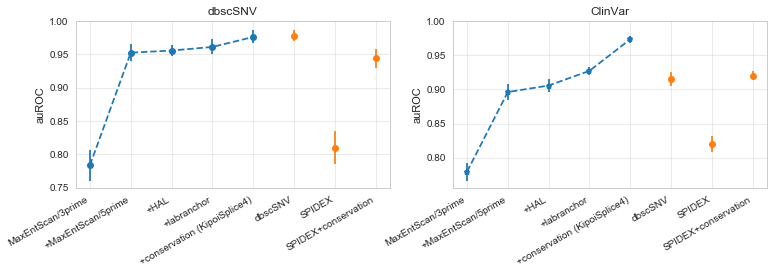

In [316]:
fig=plt.figure(figsize=(12, 4))
fig.subplots_adjust(bottom=0.3, left=0.1)
plt.subplot(121)
col1 = cm.colors[0]
col2 = cm.colors[1]
tilt = 30
plt.errorbar(kipoi_model_names, res_dbscsnv.mean_test_roc_auc[:5], yerr=res_dbscsnv.std_test_roc_auc[:5], fmt='o--', color=col1)
#plt.errorbar(res_dbscsnv.model_name[4:5], res_dbscsnv.mean_test_roc_auc[4:5], yerr=res_dbscsnv.std_test_roc_auc[4:5], fmt='o', color=col1)
plt.errorbar(other_model_names, res_dbscsnv.mean_test_roc_auc[5:], yerr=res_dbscsnv.std_test_roc_auc[5:], fmt='o', color=col2)
plt.ylabel("auROC")
#plt.errorbar(["asd"], [.9], yerr=[.1], fmt='o--')
plt.title("dbscSNV")
plt.ylim((None, 1))
plt.grid(alpha=0.4)
plt.xticks(rotation=tilt, horizontalalignment="right");
plt.subplot(122)
plt.errorbar(kipoi_model_names, res_clinvar.mean_test_roc_auc[:5], yerr=res_clinvar.std_test_roc_auc[:5], fmt='p--', color=col1)
#plt.errorbar(res_clinvar.model_name[4:5], res_clinvar.mean_test_roc_auc[4:5], yerr=res_clinvar.std_test_roc_auc[4:5], fmt='o', color=col1)
plt.errorbar(other_model_names, res_clinvar.mean_test_roc_auc[5:], yerr=res_clinvar.std_test_roc_auc[5:], fmt='o', color=col2)
plt.title("ClinVar")
plt.grid(alpha=0.4)
plt.ylim((None, 1))
plt.ylabel("auROC")
plt.xticks(rotation=tilt, horizontalalignment="right");
#plt.tight_layout(h_pad=0);
plt.savefig('plots/fig5c_clinvar_20180429.png', dpi=600)
plt.savefig('plots/fig5c_clinvar_20180429.pdf', dpi=600)
plt.close(fig)    # close the figure
fig

In [317]:
isna_clinvar = X_clinvar.filter(like="_isna", axis=1)

In [318]:
isna_clinvar['KipoiSplice4_isna'] = isna_clinvar[pd.Series(models)+"_isna"].min(axis=1)
isna_clinvar = isna_clinvar.mean().sort_index().reset_index().rename(columns={"index": "Method", 0: "NA_frac"})
isna_clinvar['Dataset'] = "ClinVar"
isna_clinvar['Method'] = isna_clinvar['Method'].str.replace("_isna", "")

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [319]:
isna_dbscsnv = X_dbscsnv.iloc[:,~X_dbscsnv.columns.str.contains("rbp_eclip")].filter(like="_isna", axis=1)
isna_dbscsnv['KipoiSplice4_isna'] = isna_dbscsnv[pd.Series(models)+"_isna"].min(axis=1)
isna_dbscsnv = isna_dbscsnv.mean().sort_index().reset_index().rename(columns={"index": "Method", 0: "NA_frac"})
isna_dbscsnv['Dataset'] = "dbscSNV"
isna_dbscsnv['Method'] = isna_dbscsnv['Method'].str.replace("_isna", "")

In [320]:
df_isna = pd.concat([isna_clinvar, isna_dbscsnv])

In [321]:
df_isna = df_isna[~df_isna.Method.str.contains("ada_score")]
df_isna = df_isna[~df_isna.Method.str.contains("max_tissue")]

In [322]:
df_isna['Method'] = df_isna.Method.replace({"dbscSNV_rf_score": "dbscSNV", 'dpsi_zscore': 'SPIDEX'})

In [323]:
methods = df_isna.Method.unique()[::-1].tolist()
datasets = df_isna.Dataset.unique()[::-1].tolist()

In [324]:
methods =['MaxEntScan/3prime',
          'MaxEntScan/5prime',
          'HAL',
          'labranchor',
          'Kipoi4',
          'dbscSNV',
          'SPIDEX'][::-1]

In [325]:
import plotnine

In [326]:
df_isna

,Method,NA_frac,Dataset
0,HAL,0.3852,ClinVar
1,KipoiSplice4,0.0000,ClinVar
2,MaxEntScan/3prime,0.5824,ClinVar
...,...,...,...
5,dbscSNV,0.0321,dbscSNV
7,SPIDEX,0.0727,dbscSNV
8,labranchor,0.6346,dbscSNV


In [327]:
methods

['SPIDEX',
 'dbscSNV',
 'Kipoi4',
 'labranchor',
 'HAL',
 'MaxEntScan/5prime',
 'MaxEntScan/3prime']

In [328]:
df_isna['Method'] = pd.Categorical(df_isna.Method, methods)

In [329]:
df_isna['Dataset'] = pd.Categorical(df_isna.Dataset, datasets)

In [330]:
df_isna = df_isna.reset_index()

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/positions/position.py:188: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  intervals = data[xminmax].drop_duplica

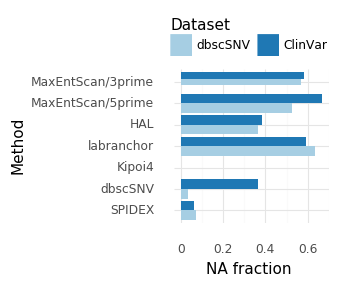

<ggplot: (8778158144509)>

In [331]:
plotnine.options.figure_size = (2,2)
gplt = ggplot(aes(x="Method", y="NA_frac", fill="Dataset"), df_isna) + \
    geom_bar(stat='identity', position='dodge') + \
    ylab("NA fraction") + \
    theme_minimal() + \
    theme(legend_box_margin=0,
          legend_direction='horizontal', 
          legend_position='top') + \
    coord_flip()  + \
        scale_fill_brewer("qual", 3)
gplt

In [332]:
gplt.save("plots/fig5b_clinvar_20180429.pdf", dpi=600)
gplt.save("plots/fig5b_clinvar_20180429.png", dpi=600)

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 2 x 2 in image.
  from_inches(height, units), units))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: plots/fig5b_clinvar_20180429.pdf
  warn('Filename: {}'.format(filename))
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-manuscript/lib/python3.6/site-packages/pandas/core/generic.py:4385: F